In [2]:
import cv2
import numpy as np
import os
import scipy.io as io
import matplotlib.pyplot as plt
import pickle

# Tensorfloww
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import random
from tqdm import tqdm

In [5]:
IMG_SIZE = 96

In [6]:
with open('../../../RGBD/train_test_2.pickle', 'rb') as fp:
    x_train,y_train,x_test,y_test = pickle.load(fp)

In [50]:
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)
#plt.imshow(x_test[10])
#plt.imshow(y_test[250,:,:,8])

(4424, 96, 96, 15)
(489, 96, 96, 15)
(489, 96, 96, 3)


## Generators

In [53]:
def my_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator,mask_data_generator)
    for (img,mask) in train_generator:
        yield (img, mask)

In [54]:
generator_x = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=35,
    height_shift_range=0.15,
    width_shift_range=0.15,
    zoom_range=0.15,
    shear_range=30,
    channel_shift_range = 0.4,
    fill_mode = 'nearest',
    #validation_split=0.1
)

generator_y = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=35,
    height_shift_range=0.15,
    width_shift_range=0.15,
    zoom_range=0.15,
    shear_range=35,
    channel_shift_range = 0.4,
    fill_mode = "constant",
    cval = 0
    #validation_split=0.1
)


In [57]:
SEED = 123
image_generator = generator_x.flow(x_train,seed=SEED,batch_size=16, shuffle=True)
mask_generator = generator_y.flow(y_train,seed=SEED,batch_size=16, shuffle=True)

In [58]:
image_generator_val = generator_x.flow(x_test,seed=SEED,batch_size=16, shuffle=True)
mask_generator_val = generator_y.flow(y_test,seed=SEED,batch_size=16, shuffle=True)

In [59]:
generator = my_generator(image_generator,mask_generator)
train_test_generator = my_generator(image_generator,mask_generator)
val_generator = my_generator(image_generator_val,mask_generator_val)

In [60]:
a = next(val_generator)

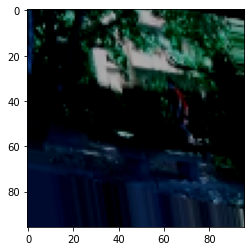

In [61]:
idx = 0
plt.imshow(a[0][idx])

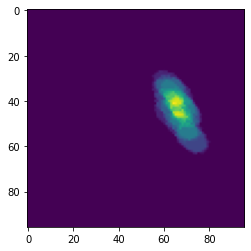

In [62]:
sumed_masks = np.zeros((IMG_SIZE,IMG_SIZE))
for j in range(15):
    sumed_masks += a[1][idx,:,:,j]
plt.imshow(sumed_masks)

## Utils

In [21]:
def get_blob_center(heatmap):
    
    heatmap_size = heatmap.shape[0]
    heatmap = np.abs(heatmap)
    heatmap = heatmap*heatmap*heatmap
    
    dx = np.array(np.arange(0,heatmap_size))
    dx = np.expand_dims(dx,0)
    dx = np.repeat(dx,heatmap_size, axis=0)
    dy = np.rot90(dx, k=3)
    
    heatmap_dx = dx*heatmap
    heatmap_dy = dy*heatmap
    
    sumed_heatmap = np.sum(heatmap)
    x = np.sum(heatmap_dx)/sumed_heatmap
    y = np.sum(heatmap_dy)/sumed_heatmap
    return np.array([x, y])

def isNaN(num):
    return num != num

def calc_blob_distances(mask_gt, mask_pred):
    distances = []
    for i in range(mask_gt.shape[-1]):
        heatmap_gt, heatmap_pred = mask_gt[:,:,i],mask_pred[:,:,i]
        p_gt = get_blob_center(heatmap_gt)
        p_pred = get_blob_center(heatmap_pred)
        distance = np.linalg.norm(p_gt-p_pred)
        if isNaN(distance):
            distance = None
        distances.append(distance)
    cleaned_distances = [x for x in distances if x != None]
    return cleaned_distances
        
def calc_oks_metric(model_to_eval, val_generator, probes):
    
    x = []
    y_gt = []
    for probe in range(probes):
        x1, y_gt1 = next(val_generator)
        x.append(x1[0])
        y_gt.append(y_gt1[0])
        if x1.shape[0] > 1:
            x.append(x1[1])
            x.append(x1[2])
            x.append(x1[3])
            x.append(x1[4])
            x.append(x1[5])
            x.append(x1[6])
            x.append(x1[7])
            y_gt.append(y_gt1[1])
            y_gt.append(y_gt1[2])
            y_gt.append(y_gt1[3])
            y_gt.append(y_gt1[4])
            y_gt.append(y_gt1[5])
            y_gt.append(y_gt1[6])
            y_gt.append(y_gt1[7])
    all_frames_distances = []
    y_pred = model_to_eval.predict(np.array(x),verbose = 0)[-1]
    x = np.array(x)
    y_gt = np.array(y_gt)
    y_pred = np.array(y_pred)
    for probe in range(probes):
        per_frame_distances = calc_blob_distances(y_gt[probe],y_pred[probe])
        per_frame_distances_avg = np.average(per_frame_distances)
        #print(per_frame_distances_avg)
        all_frames_distances.append(per_frame_distances_avg)
    average_dist = np.average(all_frames_distances)
    return average_dist

In [23]:
history_oks = []

In [24]:
class my_callback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        if batch % 500 == 0:
            print()
            print("Evaulating...")
            train_oks = calc_oks_metric(model_2, train_test_generator, 10)
            val_oks = calc_oks_metric(model_2, val_generator, 10)
            history_oks.append((train_oks,val_oks))
            print("train_oks:",train_oks,"val_oks:",val_oks)
            return None

## Model

In [79]:
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [80]:
def unet_conv(inputs, filters, kernel_size=3, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)
    if activation:
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(0.1)(x)
    return x

In [81]:
def unet_up_conv(inputs, filters, kernel_size=3, padding="same", strides=2, activation=True):
    x = Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
        use_bias=True
    )(inputs)
    if activation:
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(0.1)(x)
    return x

In [82]:
def build_generator(img_size=32, num_channels=3):
    
    inputs = keras.Input(shape=(img_size,img_size,num_channels,))
    x1 = unet_conv(inputs, filters = 32, strides = 1)
    
    x2 = unet_conv(x1, filters = 32, strides = 2)
    x3 = unet_conv(x2, filters = 32, strides = 1)
    
    x4 = unet_conv(x3, filters = 64, strides = 2)
    x5 = unet_conv(x4, filters = 64, strides = 1)
    
    x6 = unet_conv(x5, filters = 128, strides = 2)
    x7 = unet_conv(x6, filters = 128, strides = 1)
    
    
    x8 = unet_conv(x7, filters = 256, strides = 2)
    x9 = unet_conv(x8, filters = 256, strides = 1)
    
    x10 = unet_up_conv(x9, filters = 256, strides = 2)
    
    
    x = layers.concatenate([x7, x10])
    x11 = unet_conv(x, filters = 256, strides = 1)
    x12 = unet_up_conv(x11, filters = 256, strides = 2)
    
    x = layers.concatenate([x5, x12])
    x13 = unet_conv(x, filters = 128, strides = 1)
    x14 = unet_up_conv(x13, filters = 128, strides = 2)
    
    x = layers.concatenate([x3, x14])
    x15 = unet_conv(x, filters = 64, strides = 1)
    x16 = unet_up_conv(x15, filters = 64, strides = 2)
    
    x = layers.concatenate([x1, x16, inputs])
    x17 = unet_conv(x, filters = 64, strides = 1)
    
    ### 
    
    x = layers.Conv2D(15, kernel_size = 3, padding="same")(x17)
    output_1 = Activation("sigmoid", name="head1")(x)
    
    x = layers.concatenate([output_1,inputs])
    x1 = unet_conv(x, filters = 32, strides = 1)
    
    x2 = unet_conv(x1, filters = 32, strides = 2)
    x3 = unet_conv(x2, filters = 32, strides = 1)
    
    x4 = unet_conv(x3, filters = 64, strides = 2)
    x5 = unet_conv(x4, filters = 64, strides = 1)
    
    x6 = unet_conv(x5, filters = 128, strides = 2)
    x7 = unet_conv(x6, filters = 128, strides = 1)
    
    
    x8 = unet_conv(x7, filters = 256, strides = 2)
    x9 = unet_conv(x8, filters = 256, strides = 1)
    
    x10 = unet_up_conv(x9, filters = 256, strides = 2)
    
    
    x = layers.concatenate([x7, x10])
    x11 = unet_conv(x, filters = 256, strides = 1)
    x12 = unet_up_conv(x11, filters = 256, strides = 2)
    
    x = layers.concatenate([x5, x12])
    x13 = unet_conv(x, filters = 128, strides = 1)
    x14 = unet_up_conv(x13, filters = 128, strides = 2)
    
    x = layers.concatenate([x3, x14])
    x15 = unet_conv(x, filters = 64, strides = 1)
    x16 = unet_up_conv(x15, filters = 64, strides = 2)
    
    x = layers.concatenate([x1, x16, inputs])
    x17 = unet_conv(x, filters = 64, strides = 1)
    
    ### 
    
    x = layers.Conv2D(15, kernel_size = 3, padding="same")(x17)
    output = Activation("sigmoid", name="head2")(x)
    
    # Define the model
    model = keras.Model(inputs, outputs = [output_1, output])
    
    return model
    
    

In [83]:
model_2 = build_generator(IMG_SIZE)

In [63]:
#model_2.summary()

## Training

In [31]:
# global custom_history
# custom_history = []

In [32]:
# class CustomCallback(keras.callbacks.Callback):
#     def on_train_batch_end(self, batch, logs=None):
#         global custom_history
#         if (batch % 100000 == 99999):
#             keys = list(logs.keys())
#             #print("TROLO", logs["head1_loss"], logs["head2_loss"])
#             train_loss = model_2.evaluate(x_train[::10],y_train[::10])
#             test_loss = model_2.evaluate(x_test[::10],y_test[::10])
#             custom_history.append((train_loss,test_loss, [logs["loss"], logs["head1_loss"], logs["head2_loss"]]))
#             print(custom_history[-1])

In [181]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_2.compile(optimizer=opt, loss = {"head1": "mse", "head2": "mse"})

In [358]:
val_oks = calc_oks_metric(model_2, val_generator, 10)
print(val_oks)
#print(history_oks)

7.471622391568689


C:\Users\mati\AppData\Local\Temp\ipykernel_12700\3271332030.py:16: RuntimeWarning: invalid value encountered in double_scalars
  x = np.sum(heatmap_dx)/sumed_heatmap
C:\Users\mati\AppData\Local\Temp\ipykernel_12700\3271332030.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y = np.sum(heatmap_dy)/sumed_heatmap


In [359]:
val_oks = calc_oks_metric(model_2, train_test_generator, 10)
print(val_oks)

4.766090413651009


C:\Users\mati\AppData\Local\Temp\ipykernel_12700\3271332030.py:16: RuntimeWarning: invalid value encountered in double_scalars
  x = np.sum(heatmap_dx)/sumed_heatmap
C:\Users\mati\AppData\Local\Temp\ipykernel_12700\3271332030.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y = np.sum(heatmap_dy)/sumed_heatmap


In [315]:
model_2.fit(generator, epochs = 50, batch_size = 16, 
            callbacks=[my_callback()]
           )

Epoch 1/50

Evaulating...


C:\Users\mati\AppData\Local\Temp\ipykernel_12700\3271332030.py:16: RuntimeWarning: invalid value encountered in double_scalars
  x = np.sum(heatmap_dx)/sumed_heatmap
C:\Users\mati\AppData\Local\Temp\ipykernel_12700\3271332030.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y = np.sum(heatmap_dy)/sumed_heatmap


train_oks: 13.8095660960273 val_oks: 12.236621085325078
      6/Unknown - 6s 198ms/step - loss: 0.0236 - head1_loss: 0.0119 - head2_loss: 0.0117WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1556s vs `on_train_batch_end` time: 0.8785s). Check your callbacks.
    500/Unknown - 112s 215ms/step - loss: 0.0154 - head1_loss: 0.0079 - head2_loss: 0.0075
Evaulating...
train_oks: 15.031594108497709 val_oks: 15.202656592137345
   1000/Unknown - 224s 219ms/step - loss: 0.0154 - head1_loss: 0.0079 - head2_loss: 0.0075
Evaulating...
train_oks: 16.955099462151043 val_oks: 9.367754503009014
   1500/Unknown - 336s 221ms/step - loss: 0.0154 - head1_loss: 0.0079 - head2_loss: 0.0075
Evaulating...
train_oks: 16.959475310722176 val_oks: 10.594503645082973
   2000/Unknown - 449s 222ms/step - loss: 0.0154 - head1_loss: 0.0079 - head2_loss: 0.0075
Evaulating...
train_oks: 22.61783083977813 val_oks: 16.99355225373204
   2500/Unknown - 560s 222ms/step

  24500/Unknown - 5496s 224ms/step - loss: 0.0145 - head1_loss: 0.0075 - head2_loss: 0.0070
Evaulating...
train_oks: 17.704355113019098 val_oks: 8.994067923770245
  25000/Unknown - 5607s 224ms/step - loss: 0.0145 - head1_loss: 0.0075 - head2_loss: 0.0070
Evaulating...
train_oks: 15.264534245392383 val_oks: 8.83344031929698
  25500/Unknown - 5719s 224ms/step - loss: 0.0144 - head1_loss: 0.0075 - head2_loss: 0.0070
Evaulating...
train_oks: 13.384642523704727 val_oks: 8.262568781634553
  26000/Unknown - 5834s 224ms/step - loss: 0.0144 - head1_loss: 0.0075 - head2_loss: 0.0070
Evaulating...
train_oks: 13.950170982160056 val_oks: 14.253898103921298
  26500/Unknown - 5947s 224ms/step - loss: 0.0144 - head1_loss: 0.0074 - head2_loss: 0.0069
Evaulating...
train_oks: 20.69593508645257 val_oks: 13.00941015508925
  27000/Unknown - 6059s 224ms/step - loss: 0.0144 - head1_loss: 0.0074 - head2_loss: 0.0069
Evaulating...
train_oks: 15.409869136672222 val_oks: 10.637504036363183
  27500/Unknown - 6172

  49500/Unknown - 11085s 224ms/step - loss: 0.0136 - head1_loss: 0.0071 - head2_loss: 0.0065
Evaulating...
train_oks: 16.135060086164366 val_oks: 10.567224617248995
  50000/Unknown - 11196s 224ms/step - loss: 0.0135 - head1_loss: 0.0071 - head2_loss: 0.0065
Evaulating...
train_oks: 14.52572664026944 val_oks: 8.924047122673528
  50500/Unknown - 11309s 224ms/step - loss: 0.0135 - head1_loss: 0.0071 - head2_loss: 0.0065
Evaulating...
train_oks: 13.456570069946329 val_oks: 12.440731678238157
  51000/Unknown - 11421s 224ms/step - loss: 0.0135 - head1_loss: 0.0071 - head2_loss: 0.0064
Evaulating...
train_oks: 19.66154967535522 val_oks: 8.443141248628667
  51500/Unknown - 11533s 224ms/step - loss: 0.0135 - head1_loss: 0.0071 - head2_loss: 0.0064
Evaulating...
train_oks: 14.331963952703523 val_oks: 9.57073314901788
  52000/Unknown - 11645s 224ms/step - loss: 0.0135 - head1_loss: 0.0070 - head2_loss: 0.0064
Evaulating...
train_oks: 14.745673198862738 val_oks: 4.622877739900792
  52500/Unknown -

  74500/Unknown - 16692s 224ms/step - loss: 0.0127 - head1_loss: 0.0067 - head2_loss: 0.0060
Evaulating...
train_oks: 12.879404822141458 val_oks: 15.31045797339019
  75000/Unknown - 16804s 224ms/step - loss: 0.0127 - head1_loss: 0.0067 - head2_loss: 0.0060
Evaulating...
train_oks: 18.14704040357373 val_oks: 9.3122522260072
  75500/Unknown - 16916s 224ms/step - loss: 0.0127 - head1_loss: 0.0067 - head2_loss: 0.0060
Evaulating...
train_oks: 15.804238131105512 val_oks: 13.274611893450487
  76000/Unknown - 17028s 224ms/step - loss: 0.0127 - head1_loss: 0.0067 - head2_loss: 0.0060
Evaulating...
train_oks: 14.159241510946625 val_oks: 14.44370859562664
  76500/Unknown - 17140s 224ms/step - loss: 0.0126 - head1_loss: 0.0067 - head2_loss: 0.0060
Evaulating...
train_oks: 16.747614850292177 val_oks: 5.0027774162875795
  77000/Unknown - 17252s 224ms/step - loss: 0.0126 - head1_loss: 0.0066 - head2_loss: 0.0060
Evaulating...
train_oks: 11.351945186563489 val_oks: 11.19606780190674
  77500/Unknown -

  99500/Unknown - 22290s 224ms/step - loss: 0.0120 - head1_loss: 0.0063 - head2_loss: 0.0056
Evaulating...
train_oks: 14.715231881552995 val_oks: 6.465434329919813
 100000/Unknown - 22401s 224ms/step - loss: 0.0120 - head1_loss: 0.0063 - head2_loss: 0.0056
Evaulating...
train_oks: 15.795775678227145 val_oks: 5.142090489320581
 100500/Unknown - 22513s 224ms/step - loss: 0.0119 - head1_loss: 0.0063 - head2_loss: 0.0056
Evaulating...
train_oks: 12.227544496829225 val_oks: 9.25857636782926
 101000/Unknown - 22625s 224ms/step - loss: 0.0119 - head1_loss: 0.0063 - head2_loss: 0.0056
Evaulating...
train_oks: 13.205840131834345 val_oks: 8.167026812905837
 101500/Unknown - 22737s 224ms/step - loss: 0.0119 - head1_loss: 0.0063 - head2_loss: 0.0056
Evaulating...
train_oks: 21.141956483212894 val_oks: 14.790964302769527
 102000/Unknown - 22849s 224ms/step - loss: 0.0119 - head1_loss: 0.0063 - head2_loss: 0.0056
Evaulating...
train_oks: 18.189394001038558 val_oks: 5.227493729557206
 102500/Unknown 

KeyboardInterrupt: 

In [360]:
model_2.fit(generator, epochs = 50, batch_size = 16, 
            callbacks=[my_callback()]
           )

Epoch 1/50

Evaulating...


C:\Users\mati\AppData\Local\Temp\ipykernel_12700\3271332030.py:16: RuntimeWarning: invalid value encountered in double_scalars
  x = np.sum(heatmap_dx)/sumed_heatmap
C:\Users\mati\AppData\Local\Temp\ipykernel_12700\3271332030.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y = np.sum(heatmap_dy)/sumed_heatmap


train_oks: 16.904172576507683 val_oks: 10.069861316147595
      6/Unknown - 6s 193ms/step - loss: 0.0180 - head1_loss: 0.0093 - head2_loss: 0.0087WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1514s vs `on_train_batch_end` time: 0.8433s). Check your callbacks.
    500/Unknown - 112s 215ms/step - loss: 0.0091 - head1_loss: 0.0049 - head2_loss: 0.0042
Evaulating...
train_oks: 12.120055469710616 val_oks: 4.46254424563353
   1000/Unknown - 220s 215ms/step - loss: 0.0091 - head1_loss: 0.0049 - head2_loss: 0.0042
Evaulating...
train_oks: 21.446691821707955 val_oks: 6.74210421543353
   1500/Unknown - 328s 216ms/step - loss: 0.0091 - head1_loss: 0.0049 - head2_loss: 0.0042
Evaulating...
train_oks: 19.180588922006866 val_oks: 5.008187830884419
   2000/Unknown - 437s 216ms/step - loss: 0.0090 - head1_loss: 0.0049 - head2_loss: 0.0041
Evaulating...
train_oks: 14.610771053849536 val_oks: 8.602009513776274
   2500/Unknown - 545s 216ms/step 

KeyboardInterrupt: 

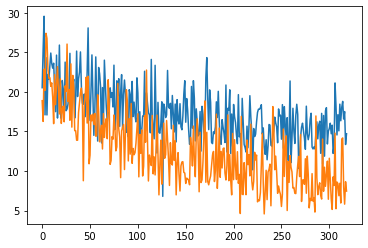

In [354]:
train_oks = [x[0] for x in history_oks]
val_oks = [x[1] for x in history_oks]
plt.plot(train_oks) 
plt.plot(val_oks)
plt.show()

In [ ]:
print(history_oks)

In [155]:
import joblib

In [156]:
joblib.dump(model_2, 'heatmap_192_hourglass_3_modules_all_keypoints_3.pkl')

INFO:tensorflow:Assets written to: ram://e90764e7-9560-4b00-a49c-9c01e567597c/assets


INFO:tensorflow:Assets written to: ram://e90764e7-9560-4b00-a49c-9c01e567597c/assets


['heatmap_192_hourglass_3_modules_all_keypoints_3.pkl']

In [25]:
model_2.save("heatmap_192_hourglass_3_modules_all_keypoints_3")

NameError: name 'model_2' is not defined

In [80]:
train_head_2 = [x[0][2] for x in custom_history]
test_head_2 = [x[2][2] for x in custom_history]
train_head_1 = [x[0][1] for x in custom_history]
test_head_1 = [x[2][1] for x in custom_history]

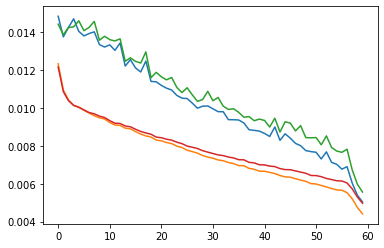

In [81]:

plt.plot(train_head_2)
#plt.set_title("train")
  
# For Cosine Function
plt.plot(test_head_2)
#plt.set_title("test")

plt.plot(train_head_1)
#plt.set_title("train")
  
# For Cosine Function
plt.plot(test_head_1)

plt.show()

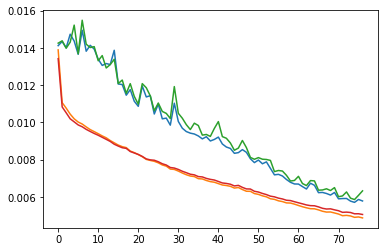

In [211]:

plt.plot(train_head_2)
#plt.set_title("train")
  
# For Cosine Function
plt.plot(test_head_2)
#plt.set_title("test")

plt.plot(train_head_1)
#plt.set_title("train")
  
# For Cosine Function
plt.plot(test_head_1)

plt.show()

## Tests

In [ ]:
intermediate_layer_model = keras.models.Model(inputs=model_2.input, outputs=model_2.get_layer("concatenate_4").output)

In [31]:
model_5 = keras.models.load_model('no_overfit')
#model_2.save("no_overfit")

In [32]:
#inter_output = intermediate_layer_model.predict(x_test[0:200])
inter_output_2 = model_5.predict(x_test[0:200])
inter_output_2 = np.array(inter_output_2)

7/7 [==============================] - 1s 103ms/step


0.10015857

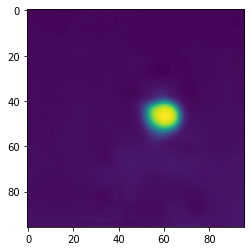

In [46]:
idx = 70
plt.imshow(inter_output_2[1,idx,:,:,0])
inter_output_2[1,idx,:,:,14].max()

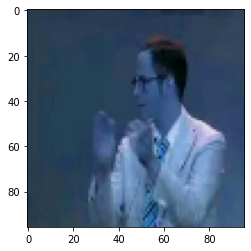

In [42]:

idx_2 = 13
plt.imshow(x_test[idx])

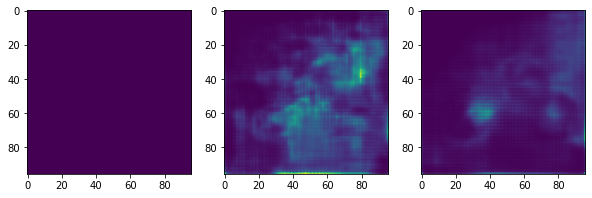

In [335]:
#f.set_figheight(15)
f, axarr = plt.subplots(1,3, figsize=(10, 10))

axarr[0].imshow(y_test[idx,:,:,idx_2])
axarr[1].imshow(inter_output_2[0][idx,:,:,idx_2])
axarr[2].imshow(inter_output_2[1][idx,:,:,idx_2])

In [336]:
model_2.evaluate(x_test,y_test, batch_size = 16)

31/31 [==============================] - 3s 57ms/step - loss: 0.0176 - head1_loss: 0.0092 - head2_loss: 0.0084


[0.017612367868423462, 0.009191948920488358, 0.008420419879257679]

In [337]:
addon = 400
per_once = 50

In [343]:
predicted = model_2.predict(x_test[addon:addon+per_once])

2/2 [==============================] - 0s 48ms/step


In [344]:
predicted = predicted[0]

In [345]:
masks_video = []

for i in range(per_once):
    sumed_masks_l = np.zeros((IMG_SIZE,IMG_SIZE,3))
    sumed_masks_r = np.zeros((IMG_SIZE,IMG_SIZE,3))
    for j in range(15):
        if (j % 2 == 0):
            sumed_masks_l[:,:,0] += predicted[i,:,:,j]
        if (j % 2 == 1):
            sumed_masks_r[:,:,2] += predicted[i,:,:,j]
            
    sumed_masks_l += sumed_masks_r
    #sumed_masks_l = sumed_masks_l**2/255.
    masks_video.append(sumed_masks_l)

In [346]:
np.array(masks_video).shape

(50, 96, 96, 3)

In [348]:
for i in range(per_once):
    cv2.imshow("window1", cv2.resize(masks_video[i]*1,(256,256)))
    cv2.imshow("window2", cv2.resize(x_test[addon+i]/1.,(256,256)))
    cv2.waitKey(200)
cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()